# Coursework 1 - Synfire chains

The aim of this coursework is to reproduce and extend the results of the following paper:

[Diesmann et al (1999) "Stable propagation of synchronous spiking in cortical neural networks"](https://www.nature.com/articles/990101) ([pdf](http://www.honda-ri.de/pubs/pdf/1406.pdf))

You can extend the code developed in the exercises in weeks 1 and 2.

You will need to read the paper, paying particular attention to the Methods section, to understand what the model is. As is often the case in older scientific papers, no code is provided and not all the details needed are given. You will need to think and experiment a bit to fill in the gaps.

You should submit your results as a Jupyter notebook that can be run on Google Colab. You should describe your code and results. Your code should be clear, and well commented, and your text should be clearly written and easy to follow. Remember, it will be assessed by 3 or more randomly selected individuals from the class. They will download and run your code, and if it does not work or they cannot understand it, you will get fewer marks.

A more detailed, step-by-step guide follows.

In [1]:
# These imports should be enough to do everything in this coursework, but feel free to use others
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import poisson

## Task 1: implement a simulator for the model in the paper

Your simulator should have the following features:

1. Leaky integrate-and-fire neuron with alpha synapse acting on the current (note: not on the membrane potential). You should have two time constants, membrane time constant and alpha synapse time constant.
2. Background noise as a Poisson process (see notes below).
3. Refractoriness (see notes below).
4. Initialisation with an input spike burst as described in the paper.
5. All-to-all connectivity between layers. That is, each neuron in layer $i$ is connected to each neuron in layer $j$ (with the same weight).
6. Delay between layers (so a spike in layer $i$ takes a fixed amount of time before arriving in layer $i+1$).

You can build your simulator iteratively adding features as you verify the properties and reproduce the plots below. For task 2A, you only need feature (1). For task 2B you need features (1-3). For task 3 onwards you need all 6 features.

Recommended approach: try to solve task 2A first using only a simulator with feature (1). Now add features (2-3) and solve task 2B. Once you've finished that, go back and check your code still works for taks 2A. Continue like this.

### Poisson background noise

You can implement Poisson background noise by computing the mean number of expected noise spikes in any time step (product of sum of input firing rates and time step size), and then at each time step drawing a random, Poisson distributed value with this mean. You can the ``poisson`` function imported above to do this. Note that in this case there are two populations of neurons, one excitatory and one inhibitory.

### Refractoriness

After a spike, the neuron shuts down (membrane potential stays at reset value and incoming spikes are ignored) for a period of time called the refractory period. You can implement this by tracking, for each neuron, the last time it spiked, and only adding spikes for neurons which haven't fired within the refractory period.

### Suggested implementation

* A function that simulates a single layer of the network, taking the output spikes of the previous layer as an input argument, and returning its own output spikes.
* A function that generates spikes for an input burst in the same format as the input/output of the simulate layer function above.

In [25]:
import numpy as np

def simulate_layer(num_neurons=None, num_time_steps=None, spikes_in=None, noise=True, delay=5):
    """
    Simulates neural activity in a layer of neurons, producing spike outputs and 
    tracking membrane potentials over time. The layer can incorporate noise and 
    a delay on incoming spikes.

    Parameters:
        num_neurons (int, optional): Number of neurons in the layer. If `spikes_in`
                                     is provided, this value is inferred from its shape.
        num_time_steps (int, optional): Number of time steps for the simulation. If
                                        `spikes_in` is provided, this value is inferred.
        spikes_in (numpy.ndarray, optional): Input spike data as a binary matrix where 
                                             rows represent neurons and columns represent 
                                             time steps.
        noise (bool, default=True): If True, adds random excitatory and inhibitory noise 
                                    to the spike input during simulation.
        delay (int, default=5): Time delay (in ms) applied to incoming spikes.

    Returns:
        tuple:
            - v_rec (numpy.ndarray): Matrix of recorded membrane potentials for each neuron 
                                     over time, with resting potential shifted for analysis.
            - spikes_out (numpy.ndarray): Matrix indicating output spikes of neurons, with
                                          rows as neurons and columns as time steps.
    """
        
    # Ensure at least one of spikes_in or (num_neurons and num_time_steps) is provided
    if spikes_in is None and (num_neurons is None or num_time_steps is None):
        raise ValueError("You need to specify either spikes_in or num_neurons and num_time_steps")
    
    # If spikes_in is provided, extract number of neurons and time steps from its shape
    if spikes_in is not None:
        num_neurons, num_time_steps = spikes_in.shape
    
    # Simulation constants
    dt = 0.1  # Time step in milliseconds
    resting_potential = -70.0  # Resting membrane potential in mV
    potential_threshold = -55.0  # Threshold potential for spiking in mV
    tau_alpha = 0.4  # Decay constant for synaptic dynamics
    tau_membrane = 10.0  # Membrane time constant
    refactory_period = 1.0  # Minimum time between spikes for a neuron
    membrane_resistance = 4.05  # Resistance affecting membrane potential change

    # Initialize input spikes matrix if spikes_in is not provided
    if spikes_in is None:
        spikes_in = np.zeros((num_neurons, num_time_steps))
    else:
        # Introduce a delay in the spike inputs by shifting spike timings
        spikes_in = np.roll(spikes_in, int(delay / dt))
        spikes_in[:, :int(delay / dt)] = 0  # Clear delayed spikes at the start
    
    # Initialize neuron states
    v = np.full(num_neurons, fill_value=resting_potential)  # Membrane potential of each neuron
    x = np.zeros(num_neurons)  # Synaptic current for ALPHA synapse
    y = np.zeros(num_neurons)  # Intermediate state for synaptic current decay
    t_last = np.full(num_neurons, fill_value=-1e9)  # Last spike time for each neuron
    v_rec = np.zeros((num_neurons, num_time_steps))  # Record of membrane potential over time
    spikes_out = np.zeros((num_neurons, num_time_steps))  # Record of spikes over time

    # Set up noise parameters if noise is enabled
    excitatory_count, inhibitory_count = 17600, 2400  # Number of excitatory and inhibitory sources
    excitatory_rate, inhibitory_rate = 2.0, 12.5  # Mean spike rate for excitatory and inhibitory inputs
    if noise:
        lambda_excitatory = excitatory_rate * excitatory_count * (dt / 1000)  # Expected excitatory spikes per timestep
        lambda_inhibitory = inhibitory_rate * inhibitory_count * (dt / 1000)  # Expected inhibitory spikes per timestep
        
        # Randomize initial membrane potential to avoid synchronization
        v = np.random.uniform(low=resting_potential, high=potential_threshold, size=num_neurons)
        
        # Add noise spikes at each time step
        for t_idx in range(num_time_steps):
            noise_excitatory = np.random.poisson(lambda_excitatory, num_neurons)
            noise_inhibitory = np.random.poisson(lambda_inhibitory, num_neurons)
            spikes_in[:, t_idx] += noise_excitatory - noise_inhibitory

    # Main simulation loop
    for t_idx in range(num_time_steps):
        t = t_idx * dt  # Current time in ms
        
        # Determine which neurons are in the refractory period
        refactored_neurons = (t - t_last) < refactory_period
        non_refactored_neurons = ~refactored_neurons
        
        # Update synaptic current dynamics
        x_prime = -x / tau_alpha  # Decay of synaptic current
        y_prime = (x - y) / tau_alpha  # Intermediate state decay
        x += x_prime * dt + spikes_in[:, t_idx]  # Integrate input spikes into x
        y += y_prime * dt  # Update y based on decayed x
        
        # Calculate membrane potential change
        v_prime = (membrane_resistance * y + resting_potential - v) / tau_membrane
        v[non_refactored_neurons] += v_prime[non_refactored_neurons] * dt  # Update potential for non-refractory neurons
        v[refactored_neurons] = resting_potential  # Reset potential for refractory neurons
        
        # Determine if neurons have spiked
        spiked_neurons = v >= potential_threshold
        v[spiked_neurons] = resting_potential  # Reset potential after spike
        v_rec[:, t_idx] = v  # Record membrane potential at this timestep
        spikes_out[:, t_idx] = spiked_neurons  # Record spikes
        
        # Update last spike time for neurons that spiked
        t_last[spiked_neurons] = t
        
    return v_rec + 70, spikes_out  # Shift recorded potentials for easier analysis

def input_burst(num_neurons=100, num_active=50, offset=0, sigma=0, num_time_steps=700, dt=0.1):
    # Create a burst of spikes for a subset of neurons, with variability in timing
    sigma = sigma / dt  # Adjust standard deviation based on time step size
    spikes = np.zeros((num_neurons, num_time_steps))
    
    # Select random subset of neurons to be active
    spiking_neurons = np.random.choice(num_neurons, num_active, replace=False)
    
    # Generate normally distributed spike times around the offset
    spike_time_distribution = np.random.normal(loc=offset, scale=sigma, size=num_active).astype(int)
    valid_spike_times = np.clip(spike_time_distribution, 0, num_time_steps - 1)  # Keep times within bounds
    
    # Set spikes for chosen neurons at the determined times
    spikes[spiking_neurons, valid_spike_times] = 1

    return spikes

# Function for mapping spikes from one layer to another
def all_to_all(spikes, n_out=None):
    # Sum spikes across all neurons in each time step
    s = spikes.sum(axis=0)[None, :]
    
    # If output neuron count is unspecified, default to the number of input neurons
    if n_out is None:
        n_out = spikes.shape[0]
    
    # Broadcast summed spike train across all output neurons
    return np.repeat(s, n_out, axis=0)


## Task 2: validate neuron, synapse and network properties

### Task 2A: validate postsynaptic potential



Verify that you have implemented the neuron and synapse model correctly by feeding it a single input spike, plotting the membrane potential (postsynaptic potential, PSP) and checking that the time to peak, and peak value are as given in the paper. It doesn't have to be absolutely perfect, just close enough.

# Differential Equations for the Neuron Model with ALPHA Synapse Dynamics

This model simulates a layer of neurons with leaky integrate-and-fire (LIF) dynamics, incorporating an ALPHA synapse model to represent the synaptic current response to input spikes.

## 1. Synaptic Current Dynamics (ALPHA Synapse)

The ALPHA synapse model describes the change in synaptic current $x$ and an intermediate variable $y$ in response to spikes. When a spike occurs, $x$ increases, then decays over time.

The dynamics are governed by the following differential equations:

$$
\frac{dx}{dt} = -\frac{x}{\tau_{\alpha}} + \text{spikes\_in}(t)
$$

$$
\frac{dy}{dt} = \frac{x - y}{\tau_{\alpha}}
$$

where:
- $x$ is the synaptic current, driven by input spikes.
- $y$ is an intermediate state variable that tracks the decayed value of $x$.
- $\tau_{\alpha}$ is the synaptic time constant, which determines the rate of decay.
- $\text{spikes\_in}(t)$ represents the input spikes at time $t$, acting as a driving force to increase $x$.

## 2. Membrane Potential Dynamics

The neuron’s membrane potential $v$ changes according to the LIF model, influenced by $y$, which represents the cumulative effect of input spikes decaying over time.

The membrane potential $v$ is described by:

$$
\frac{dv}{dt} = \frac{R_m \cdot y + v_{\text{rest}} - v}{\tau_m}
$$

where:
- $v$ is the membrane potential of the neuron.
- $R_m$ is the membrane resistance, scaling the contribution of $y$ to the membrane potential.
- $v_{\text{rest}}$ is the resting potential, to which the membrane potential returns in the absence of input.
- $\tau_m$ is the membrane time constant, controlling how quickly the membrane potential responds to changes in synaptic input.

The membrane potential $v$ is reset to $v_{\text{rest}}$ whenever it crosses a threshold potential $v_{\text{thresh}}$, which generates an output spike.

## 3. Refractory Period

To prevent immediate re-firing, neurons enter a refractory period after spiking. During this period, $v$ is held at $v_{\text{rest}}$, regardless of the synaptic input. This refractory period is managed by setting $v = v_{\text{rest}}$ if the time since the last spike is less than the specified refractory time.


Alpha PSP verification
NOTE: Peak is set at 0.14 as the paper sets this value, it can be normalized to 0.08 by dividing by 1.75
  Maximum of PSP is 0.1400 and should be 0.14
  Maximum is attained at time 1.70 and should be 1.7



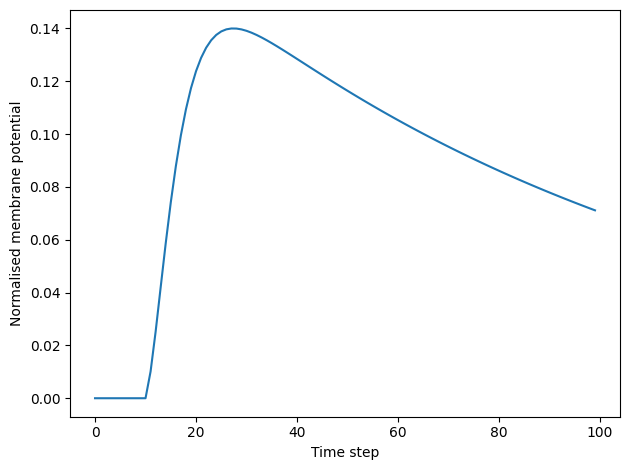

In [26]:
s_in = np.zeros((1, 100)) 
s_in[0, 10] = 1 
v, s = simulate_layer(spikes_in=s_in, noise=False, delay=0)
plt.figure()
plt.plot(v[0, :])
plt.xlabel('Time step')
plt.ylabel('Normalised membrane potential')
plt.tight_layout()
print('Alpha PSP verification')
print("NOTE: Peak is set at 0.14 as the paper sets this value, it can be normalized to 0.08 by dividing by 1.75")
print(f'  Maximum of PSP is {v.max():.4f} and should be 0.14') 
print(f'  Maximum is attained at time {(v.argmax()-10)*0.1:.2f} and should be 1.7') 
print()

Expected results:

![Expected results](result_2a.png)

### Task 2B: validate background noise

Verify that in the absence of any input spikes, neurons in the network fire noise spikes at approximately the rate given in the paper, and that the mean and standard deviation of the membrane potential is as given in the paper. Plot the output spikes and 5 membrane potentials to check that the results seem sensible.

Background firing rate verification
  Mean rate is 2.8 Hz, should be 2
  Membrane potential mean is 7.89, should be 8.25
  Membrane potential std is 2.94, should be 2.85


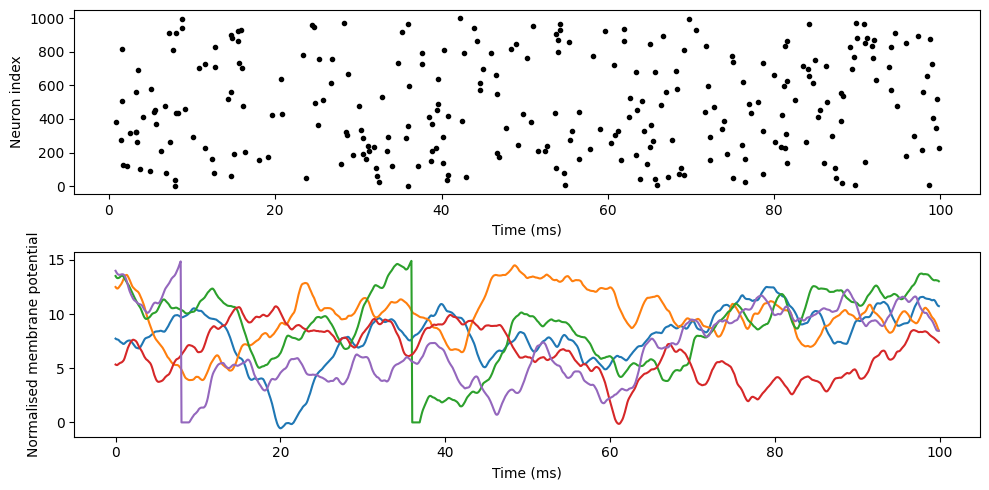

In [27]:
v, s = simulate_layer(num_neurons=1000, num_time_steps=1000)
i, t = s.nonzero()
t = t*0.1 
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.plot(t, i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.subplot(212)
plt.plot(np.arange(1000)*0.1, v[:5, :1000].T)
plt.xlabel('Time (ms)')
plt.ylabel('Normalised membrane potential')
plt.tight_layout()
print('Background firing rate verification')
print(f'  Mean rate is {s.sum()/(1000*1000*0.1*1e-3):.1f} Hz, should be 2') 
print(f'  Membrane potential mean is {v.mean():.2f}, should be 8.25') 
print(f'  Membrane potential std is {v.std():.2f}, should be 2.85') 

Expected results:

![Expected results](results_2b.png)

## Task 3: reproduce figures 1d and 1e from the paper

The plotting doesn't have to be perfect, but it should be recognisably similar to the paper.

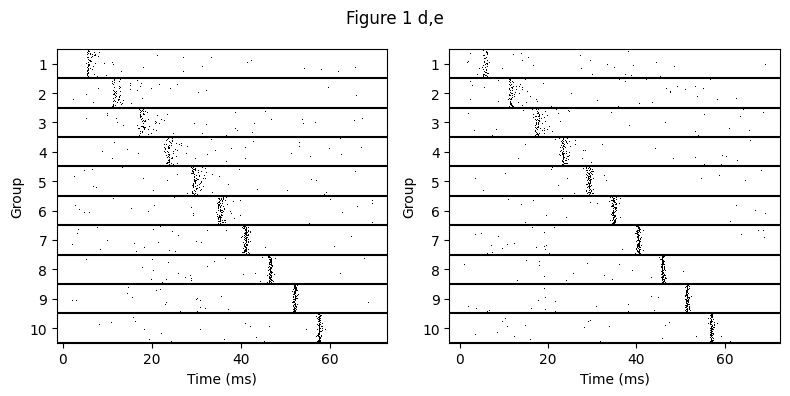

In [28]:
num_neurons = 100
plt.figure(figsize=(8, 4))
a_values = [50,48]
for plotidx, a in enumerate(a_values):
    s = input_burst(num_neurons=num_neurons, num_active=a)
    plt.subplot(1, 2, plotidx+1)
    for layer in range(10):
        s_accumulated = all_to_all(s)
        _, s = simulate_layer(spikes_in=s_accumulated)
        i, t = s.nonzero()
        plt.plot(t*0.1, i/100+9-layer, ',k')
        plt.axhline(layer, c='k')
    plt.ylim(0, 10)
    plt.yticks(np.arange(10)+0.5, np.arange(1, 11)[::-1])
    plt.xlabel('Time (ms)')
    plt.ylabel('Group')
plt.suptitle('Figure 1 d,e')
plt.tight_layout();

Expected results (may not be exactly the same each time you run):

![Expected results](result_3.png)

## Task 4: reproduce figures 2c and 2d

In this case, the paper is lacking a lot of detail in how to estimate the probability and spread of an output spike. You are unlikely to be able to perfectly reproduce the output, but you should be able to get something similar and justify your results, or explain why you think the paper got it wrong if you disagree.

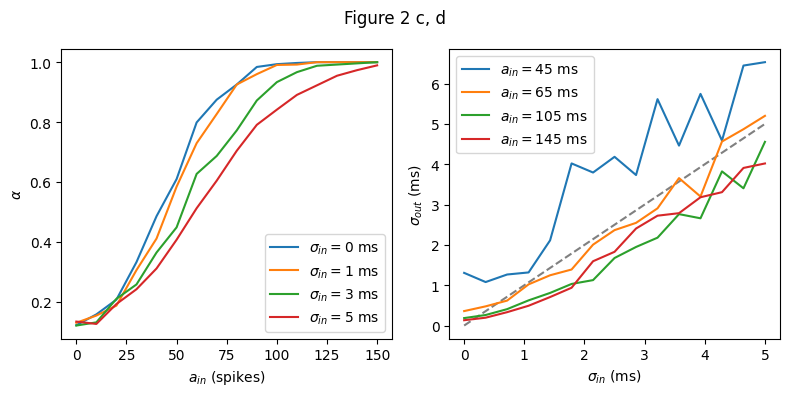

In [43]:
import numpy as np

def estimate_pulse_parameters(s, num_neurons):
    """
    Estimate the proportion of neurons that spike (alpha) and the temporal spread
    (sigma_out) of these spikes in a neural network layer.
    
    Parameters:
        s (numpy.ndarray): Spike data matrix with rows representing neurons 
                           and columns representing time steps.
        num_neurons (int): Total number of neurons in the layer.
    
    Returns:
        tuple:
            - alpha (float): Proportion of neurons that spiked, capped by num_neurons.
            - sigma_out (float): Standard deviation of spike times, providing a measure 
                                 of spike spread, with outliers removed.
    """
    # Identify neurons that spiked at least once across all time steps
    spiking_neurons_array = np.sum(s, axis=1) > 0
    total_spiking_neurons = np.sum(spiking_neurons_array)
    
    # Limit the count of spiking neurons to the number of available neurons
    active = min(total_spiking_neurons, num_neurons)
    
    # Calculate alpha as the proportion of spiking neurons
    alpha = active / num_neurons if num_neurons > 0 else 0
    
    # Extract the time indices (spike times) where spikes occur
    _, spikes = s.nonzero()
    
    if spikes.size > 0:
        # Sort spike times for further analysis
        sorted_timestamps = np.sort(spikes)
        
        # Calculate the interquartile range (IQR) for spike times to filter outliers
        Q1 = np.percentile(spikes, 25)
        Q3 = np.percentile(spikes, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter spike times to remove outliers beyond IQR bounds
        filtered_spikes = sorted_timestamps[
            (sorted_timestamps >= lower_bound) & (sorted_timestamps <= upper_bound)
        ]
        
        # Calculate sigma_out as the standard deviation of filtered spike times
        sigma_out = np.std(filtered_spikes) * 0.1 if filtered_spikes.size > 0 else 0
    else:
        # Default to 0 if there are no spikes
        sigma_out = 0

    return alpha, sigma_out

def neural_transmission(a_in, sigma_in, repeats=5, dt=0.1):
    """
    Simulate neural transmission by generating and processing spike bursts through
    a neural layer multiple times, averaging results to reduce noise.
    
    Parameters:
        a_in (int): Number of active neurons in the input burst.
        sigma_in (float): Temporal spread of spikes in the input burst.
        repeats (int): Number of simulation repetitions for averaging (default: 5).
        dt (float): Time step size for simulation (default: 0.1).
    
    Returns:
        tuple:
            - avg_alpha (float): Average proportion of neurons that spiked across 
                                 all iterations.
            - avg_sigma (float): Average temporal spread of spikes across all iterations.
    """
    # Initialize cumulative metrics to accumulate over multiple runs
    cumulative_alpha, cumulative_sigma = 0, 0
    offset = 100  # Time offset for input burst initiation
    num_time_steps = 400  # Total number of time steps for simulation
    neurons_count = 150  # Total neurons in the neural layer
    
    for _ in range(repeats):
        # Generate a spike burst with a specific active neuron count and temporal spread
        spike_burst = input_burst(num_neurons=neurons_count, num_active=a_in, 
                                  offset=offset, sigma=sigma_in, dt=dt, 
                                  num_time_steps=num_time_steps)
        
        # Transform spike burst with all-to-all connectivity for neuron interactions
        spike_burst = all_to_all(spike_burst)
        
        # Simulate neural layer with the generated spikes as input
        _, output_spikes = simulate_layer(num_neurons=neurons_count, spikes_in=spike_burst, 
                                          noise=True, num_time_steps=num_time_steps, delay=0)
        
        # Estimate the proportion of neurons spiking and spread in output spike times
        alpha_iter, sigma_iter = estimate_pulse_parameters(output_spikes, neurons_count)
        
        # Accumulate alpha and sigma values over each iteration
        cumulative_alpha += alpha_iter
        cumulative_sigma += sigma_iter
    
    # Calculate averages over all iterations for final results
    avg_alpha = cumulative_alpha / repeats
    avg_sigma = cumulative_sigma / repeats

    return avg_alpha, avg_sigma

plt.figure(figsize=(8, 4))
plt.subplot(121)
for sigma in [0, 1, 3, 5]:
    A_IN = np.arange(0, 150+1, 10)
    ALPHA = [neural_transmission(a_in, sigma)[0] for a_in in A_IN]
    plt.plot(A_IN, ALPHA, label=f'$\\sigma_{{in}}={sigma}$ ms')
plt.xlabel(r'$a_{in}$ (spikes)')
plt.ylabel(r'$\alpha$')
plt.legend(loc='best')
plt.subplot(122)
for a_in in [45, 65, 105, 145]:
    SIGMA_IN = np.linspace(0, 5, 15)
    SIGMA_OUT = [neural_transmission(a_in, sigma_in)[1] for sigma_in in SIGMA_IN]
    plt.plot(SIGMA_IN, SIGMA_OUT, label=f'$a_{{in}}={a_in}$ ms')
plt.plot([0, 5], [0, 5], ls='--', c='grey', zorder=-1)
plt.xlabel(r'$\sigma_{in}$ (ms)')
plt.ylabel(r'$\sigma_{out}$ (ms)')
plt.legend(loc='best')
plt.suptitle('Figure 2 c, d')
plt.tight_layout();

Expected results (as you can see, not exactly the same as in the paper which I couldn't reproduce perfectly):

![Expected results](result_4.png)

## Task 5: reproduce figure 3c

It is sufficient to plot some of the trajectories, and not the separatrix (dashed line).

Due to the random nature of noise, different plots may appear every time this block is ran


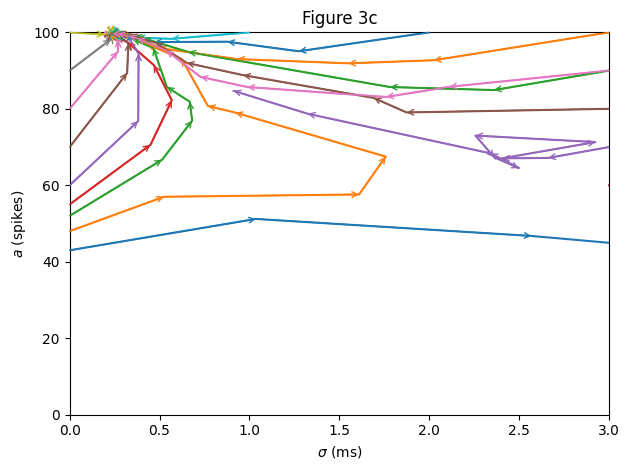

In [42]:
starting_points = [
    (43, 0), (48, 0), (52, 0), (55, 0), (60, 0), (70, 0), (80, 0), (90, 0), 
    (100, 0), (100, 1), (100, 2), (100, 3), (90, 3), (60, 3), (70, 3), 
    (80, 3), (90, 3)
]

repeats = 0        # Number of repetitions to average the calculation, smoothing the trajectory and reducing noise impact
dt = 0.1            # Time step in milliseconds
num_neurons = 100   # Number of neurons in the simulated layer
offset = 100        # Offset to ensure that spike times are positive and within the given timeframe


def calculate_mean_values(num_neurons, repeats, s):
    """
    Calculate the mean values of alpha (spike probability) and sigma (spike timing spread) 
    over multiple simulation runs to smooth noise and obtain reliable average values.

    Parameters:
        num_neurons (int): Number of neurons in the neural layer.
        repeats (int): Number of repetitions to average the results.
        s (numpy.ndarray): Input spike matrix representing a burst of spikes.

    Returns:
        tuple:
            - mean_alpha (float): Mean of calculated alpha values across runs, indicating 
                                  the proportion of neurons that spike.
            - mean_sigma (float): Mean of calculated sigma values, representing the spread 
                                  of spike timings.
            - s_1 (numpy.ndarray): Final spike matrix after `simulate_layer` for reference.
    """
    a_sum = 0         # Accumulated sum of spike probabilities over repeats
    sigma_sum = 0     # Accumulated sum of spread values over repeats
    
    for _ in range(repeats):
        # Spread input spikes to all neurons
        s_1 = all_to_all(s)
        
        # Simulate neuron layer response to input spikes
        _, s_1 = simulate_layer(num_neurons=num_neurons, spikes_in=s_1, noise=True, 
                                num_time_steps=400, delay=0)

        # Calculate alpha (spike probability) and sigma (spread) for current run
        alpha_temp, sigma_temp = estimate_pulse_parameters(s_1, num_neurons)
        
        # Convert alpha to integer neuron count
        a_temp = int(alpha_temp * num_neurons)
        
        # Accumulate alpha and sigma values
        a_sum += a_temp
        sigma_sum += sigma_temp

    # Return average values and the final spike matrix
    return a_sum / repeats, sigma_sum / repeats, s_1


# Iterate over each starting point to simulate and plot spike trajectories
for idx, (a, sigma) in enumerate(starting_points):
    # Initialize lists to record alpha (A) and sigma values (SIGMA) for each point
    A, SIGMA = [a], [sigma]
    
    # Generate an initial burst of spikes for the specified number of active neurons (a) and sigma
    s = input_burst(num_neurons=num_neurons, num_active=a, offset=offset, sigma=sigma, 
                    dt=dt, num_time_steps=400)

    # Repeat the calculation to capture the trajectory of alpha and sigma values
    for _ in range(10):
        # Append current values to record lists
        A.append(a)
        SIGMA.append(sigma)
        
        # Calculate mean alpha and sigma for the current parameters
        a, sigma, s = calculate_mean_values(num_neurons, repeats, s)

    # Plot alpha vs. sigma trajectory for the current starting point
    plt.plot(SIGMA, A, c=f'C{idx}')
    
    # Add arrows to indicate progression along the trajectory
    for i in range(len(SIGMA) - 1):
        plt.annotate('', (SIGMA[i + 1], A[i + 1]), xytext=(SIGMA[i], A[i]),
                     arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0, color=f'C{idx}'))

print("Due to the random nature of noise, different plots may appear everytime this block is ran")
plt.xlim(0, 3)
plt.ylim(0, 100)
plt.xlabel(r'$\sigma$ (ms)')
plt.ylabel('$a$ (spikes)')
plt.title('Figure 3c')
plt.tight_layout()

Expected results:

![Expected results](result_5.png)


## Task 6 (optional extra credit)

It is possible to obtain a first class grade from the parts above. This part is for extra credit.

Investigate some aspect of the model that you think is interesting and is not covered in the paper. Explain why you think it's interesting and present your results coherently.

Some ideas (but feel free to use your own):
* Do the results depend on the choice of model parameters given in the paper? How precisely?
* Do the results depend on the choice of synapse model in the paper?
* Do the results depend on all-to-all connectivity between layers?


# Comparison of Synapse Models: ALPHA, EXP, and BI

## 1. ALPHA Synapse Model

The ALPHA synapse model describes the synaptic current dynamics using two variables: $x$ (synaptic current) and $y$ (intermediate state). The equations governing the dynamics are:

$$
\frac{dx}{dt} = -\frac{x}{\tau_{\alpha}} + \text{spikes\_in}(t)
$$

$$
\frac{dy}{dt} = \frac{x - y}{\tau_{\alpha}}
$$

**Characteristics:**
- $x$ increases in response to spikes and decays over time.
- $y$ tracks the decay of $x$, smoothing the synaptic response.
- The model captures the gradual decay of synaptic current, which influences the membrane potential $v$ of the neuron.

## 2. Exponential (EXP) Synapse Model

The exponential synapse model is implemented with a single state variable $y$. The update equation governing the dynamics is:

$$
\frac{dy}{dt} = -\frac{y}{\tau_{\text{exp}}} + \text{spikes\_in}(t)
$$

**Characteristics:**
- $y$ decays exponentially, influenced directly by spikes.
- The model allows for immediate responses to input spikes, with a straightforward decay characteristic.

## 3. Biexponential (BI) Synapse Model

The biexponential synapse model includes two state variables, $x$ and $y$, to account for different time constants. The dynamics are represented by:

$$
\frac{dx}{dt} = -\frac{x}{\tau_{\text{bi}, 0}}
$$

$$
\frac{dy}{dt} = \frac{x - y}{\tau_{\text{bi}, 1}}
$$

**Characteristics:**
- $x$ decays exponentially, while $y$ responds to the difference between $x$ and $y$, allowing for a more complex response to synaptic input.
- This model captures fast and slow components of synaptic dynamics, leading to more nuanced behavior.

## Summary of Differences

| Feature              | ALPHA Synapse               | EXP Synapse              | BI Synapse               |
|----------------------|-----------------------------|--------------------------|--------------------------|
| State Variables      | $x$, $y$                    | $y$                      | $x$, $y$                 |
| Decay Dynamics       | ALPHA decay with feedback    | Single exponential decay | Dual exponential decay    |
| Response to Spikes   | Gradual increase and decay   | Immediate response       | Fast and slow responses   |
| Complexity           | Moderate                     | Low                      | High                     |




In [44]:
# Define the synapse type (Alpha (ALPHA), Exponential (EXP), or Bi-exponential (BI)) to model, currently set to "BI"

# GLOBAL
SYNAPSE = "BI"
RESTING_POTENTIAL = -70.0
POTENTIAL_THRESHOLD = -55.0

def run_sim(num_time_steps, spikes_in, v_rec, spikes_out, v, num_neurons):
    # Define common parameters
    dt = 0.1
    tau_alpha = 0.4
    tau_exp = 0.387 
    tau_bi = (0.5, 1.77)  # Bi-exponential time constants
    tau_membrane = 10.0
    refactory_period = 1.0
    membrane_resistance = 4.05

    # Initialize neuron state variables
    x = np.zeros(num_neurons)  # Intermediate state for synaptic current
    y = np.zeros(num_neurons)  # Synaptic current
    t_last = np.full(num_neurons, fill_value=-1e9)  # Last spike timestamp

    if SYNAPSE == "ALPHA":
        # Alpha synapse model: input decays over tau_alpha, with y tracking x's decay
        for t_idx in range(num_time_steps):
            t = t_idx * dt
            refactored_neurons = (t - t_last) < refactory_period
            non_refactored_neurons = ~refactored_neurons

            # Update x and y using differential equations for alpha synapse
            x_prime = -x / tau_alpha
            y_prime = (x - y) / tau_alpha
            x += x_prime * dt + spikes_in[:, t_idx]
            y += y_prime * dt
            
            # Compute membrane potential update
            v_prime = (membrane_resistance * y + RESTING_POTENTIAL - v) / tau_membrane
            v[non_refactored_neurons] += v_prime[non_refactored_neurons] * dt
            v[refactored_neurons] = RESTING_POTENTIAL

            # Update spike and reset potentials as needed
            spiked_neurons = v >= POTENTIAL_THRESHOLD
            v[spiked_neurons] = RESTING_POTENTIAL
            v_rec[:, t_idx] = v 
            spikes_out[:, t_idx] = spiked_neurons
            t_last[spiked_neurons] = t

    elif SYNAPSE == "EXP":
        # Exponential synapse model: simpler decay of current y with tau_exp
        for t_idx in range(num_time_steps):
            t = t_idx * dt
            refactored_neurons = (t - t_last) < refactory_period
            non_refactored_neurons = ~refactored_neurons

            # Update y using the exponential decay model
            y_prime = -y / tau_exp
            y += y_prime * dt + spikes_in[:, t_idx]

            # Compute membrane potential update
            v_prime = (membrane_resistance * y + RESTING_POTENTIAL - v) / tau_membrane
            v[non_refactored_neurons] += v_prime[non_refactored_neurons] * dt
            v[refactored_neurons] = RESTING_POTENTIAL

            # Update spike and reset potentials as needed
            spiked_neurons = v >= POTENTIAL_THRESHOLD
            v[spiked_neurons] = RESTING_POTENTIAL
            v_rec[:, t_idx] = v 
            spikes_out[:, t_idx] = spiked_neurons
            t_last[spiked_neurons] = t

    elif SYNAPSE == "BI":
        # Bi-exponential synapse model: decay in x and y with separate time constants
        for t_idx in range(num_time_steps):
            t = t_idx * dt
            refactored_neurons = (t - t_last) < refactory_period
            non_refactored_neurons = ~refactored_neurons

            # Update x and y using bi-exponential model with distinct tau values
            x_prime = -x / tau_bi[0]  # Faster decay in x
            y_prime = (x - y) / tau_bi[1]  # Slower decay in y
            x += x_prime * dt + spikes_in[:, t_idx]
            y += y_prime * dt

            # Compute membrane potential update
            v_prime = (membrane_resistance * y + RESTING_POTENTIAL - v) / tau_membrane
            v[non_refactored_neurons] += v_prime[non_refactored_neurons] * dt
            v[refactored_neurons] = RESTING_POTENTIAL

            # Update spike and reset potentials as needed
            spiked_neurons = v >= POTENTIAL_THRESHOLD
            v[spiked_neurons] = RESTING_POTENTIAL
            v_rec[:, t_idx] = v 
            spikes_out[:, t_idx] = spiked_neurons
            t_last[spiked_neurons] = t


def simulate_layer_2(num_neurons=None, num_time_steps=None, spikes_in=None, noise=True, delay=5):
    if spikes_in is None and (num_neurons is None or num_time_steps is None):
        raise ValueError("You need to specify either spikes_in or num_neurons and num_time_steps")
    if spikes_in is not None:
        num_neurons, num_time_steps = spikes_in.shape

    if spikes_in is None:
        spikes_in = np.zeros((num_neurons, num_time_steps))
    else:
        spikes_in = np.roll(spikes_in,delay/dt) 
        spikes_in[:,:int(delay/dt)] = 0
 
    v = np.full(num_neurons,fill_value=-70.0) 

    v_rec = np.zeros((num_neurons, num_time_steps))
    spikes_out = np.zeros((num_neurons, num_time_steps))

    excitatory_count, inhibitory_count = 17600, 2400        
    excitatory_rate, inhibitory_rate = 2.0, 12.5
    if noise:
        lambda_excitatory = excitatory_rate * excitatory_count * (dt/1000)  
        lambda_inhibitory = inhibitory_rate * inhibitory_count * (dt/1000)
        v = np.random.uniform(low=RESTING_POTENTIAL, high=POTENTIAL_THRESHOLD, size=num_neurons)
        for t_idx in range(num_time_steps):
            noise_excitatory = np.random.poisson(lambda_excitatory, num_neurons)
            noise_inhibitory = np.random.poisson(lambda_inhibitory, num_neurons)
            spikes_in[:, t_idx] += noise_excitatory - noise_inhibitory
    
    run_sim(num_time_steps, spikes_in, v_rec, spikes_out, v, num_neurons)
        
    return (v_rec+70), spikes_out


ALPHA PSP verification
  Maximum of PSP is 0.1400
  Maximum is attained at time 1.70 ms

EXP PSP verification
  Maximum of PSP is 0.1400
  Maximum is attained at time 1.10 ms

BI PSP verification
  Maximum of PSP is 0.1400
  Maximum is attained at time 4.10 ms



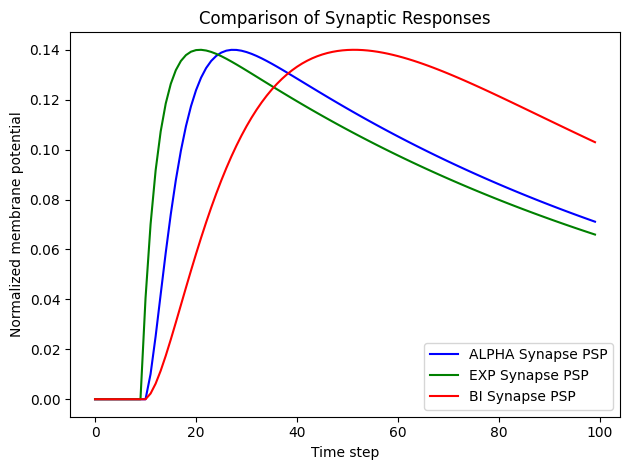

In [21]:
s_in = np.zeros((1, 100))   
s_in[0, 10] = 1             

synapse_types = ["ALPHA", "EXP", "BI"] # Synapse types to test
colors = ["blue", "green", "red"]  # Color for each synapse type

plt.figure()

for i, SYNAPSE in enumerate(synapse_types):
    v, s = simulate_layer_2(spikes_in=s_in, noise=False, delay=0)
    
    plt.plot(v[0, :], label=f'{SYNAPSE} Synapse PSP', color=colors[i])
    print(f'{SYNAPSE} PSP verification')
    print(f'  Maximum of PSP is {v.max():.4f}')
    print(f'  Maximum is attained at time {(v.argmax() - 10) * 0.1:.2f} ms')
    print()

# Labeling the plot
plt.xlabel('Time step')
plt.ylabel('Normalized membrane potential')
plt.legend()
plt.title('Comparison of Synaptic Responses')
plt.tight_layout()
plt.show()



## Observations

The observations made include maintaining the maximum PSP (1.4) as set in the paper to compare the time taken to attain this value.
 
- **ALPHA Synapse**: The maximum postsynaptic potential (PSP) reached is **0.1400**, attained at **1.70 ms**. This indicates a gradual increase and decay in response to the input spike.

- **EXP Synapse**: The maximum PSP is also **0.1400**, but it occurs earlier at **1.10 ms**. This reflects a quicker response to the input spike compared to the ALPHA synapse.

- **BI Synapse**: The maximum PSP is also **0.1400**, occurring at **4.10 ms**. This suggests that the biexponential model may be capturing a longer-lasting effect or a delayed response to the input spike.

Overall, while the ALPHA and EXP synapses produce similar peak amplitudes, their timing differs, indicating that the choice of synapse model significantly affects the timing and shape of neuronal responses. Exponential was the quickest, followed by Alpha, then Bi-exponential trailing significantly.


Background firing rate verification
  Mean rate for ALPHA is 3.0 Hz, should be 2
  Membrane potential for ALPHA mean is 7.84, should be 8.25
  Membrane potential for ALPHA std is 2.94, should be 2.85


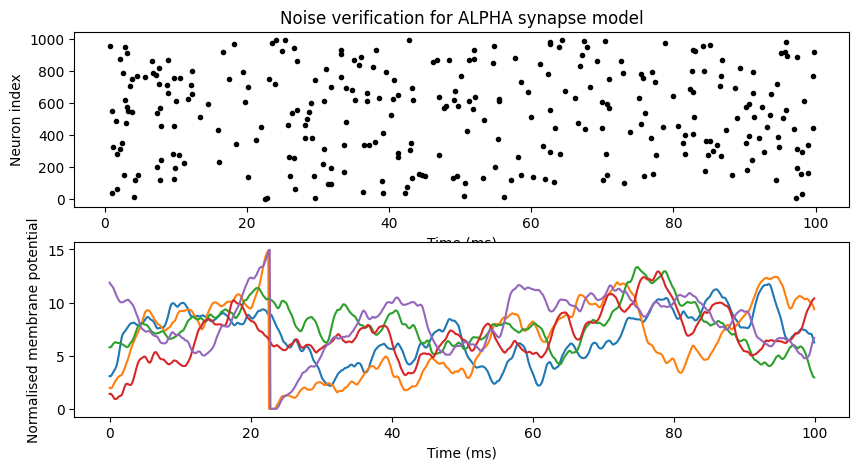

Background firing rate verification
  Mean rate for EXP is 2.5 Hz, should be 2
  Membrane potential for EXP mean is 7.62, should be 8.25
  Membrane potential for EXP std is 2.92, should be 2.85


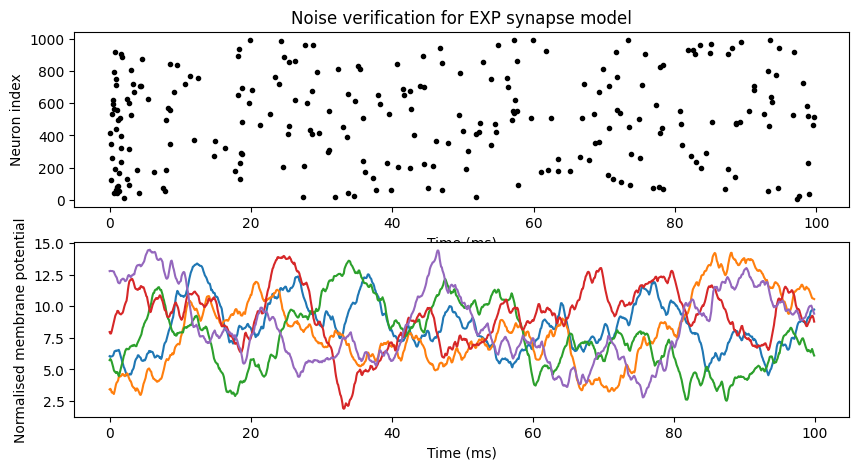

Background firing rate verification
  Mean rate for BI is 9.9 Hz, should be 2
  Membrane potential for BI mean is 8.51, should be 8.25
  Membrane potential for BI std is 3.36, should be 2.85


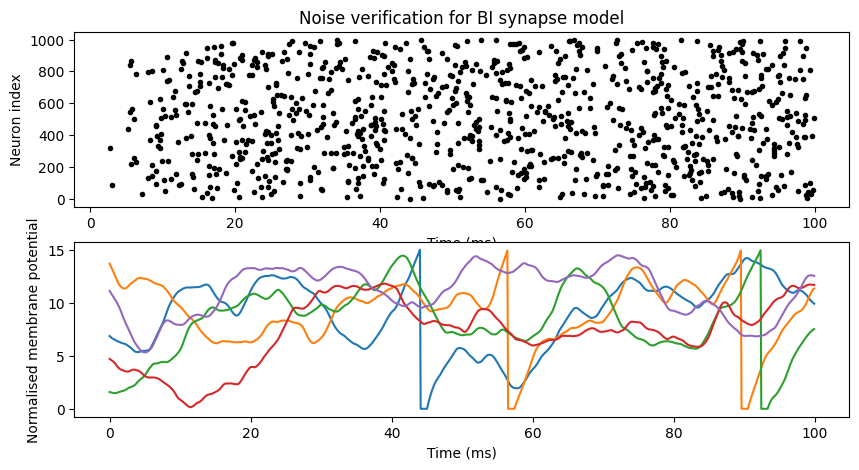

In [45]:
for i, SYNAPSE in enumerate(synapse_types):
    v, s = simulate_layer_2(num_neurons=1000, num_time_steps=1000)
    i, t = s.nonzero()
    t = t * 0.1  
    plt.figure(figsize=(10, 5))
    plt.subplot(211)
    plt.title(f'Noise verification for {SYNAPSE} synapse model')
    plt.plot(t, i, '.k')
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    plt.subplot(212)
    plt.plot(np.arange(1000) * 0.1, v[:5, :1000].T)
    plt.xlabel('Time (ms)')
    plt.ylabel('Normalised membrane potential')
    print('Background firing rate verification')
    print(f'  Mean rate for {SYNAPSE} is {s.sum() / (1000 * 1000 * 0.1 * 1e-3):.1f} Hz, should be 2')  
    print(f'  Membrane potential for {SYNAPSE} mean is {v.mean():.2f}, should be 8.25')  
    print(f'  Membrane potential for {SYNAPSE} std is {v.std():.2f}, should be 2.85')
    plt.show()


## Observations

- The **ALPHA** and **EXP** synapses show results that are relatively close to expected values for mean firing rate and membrane potential, indicating good performance in simulating neuronal activity.

- In contrast, the **BI** synapse exhibits a significant discrepancy in mean firing rate, being much higher than expected. This could be due to the dual exponential dynamics in the BI model, which may lead to a prolonged synaptic response and increased neuronal firing compared to the simpler ALPHA and EXP models.


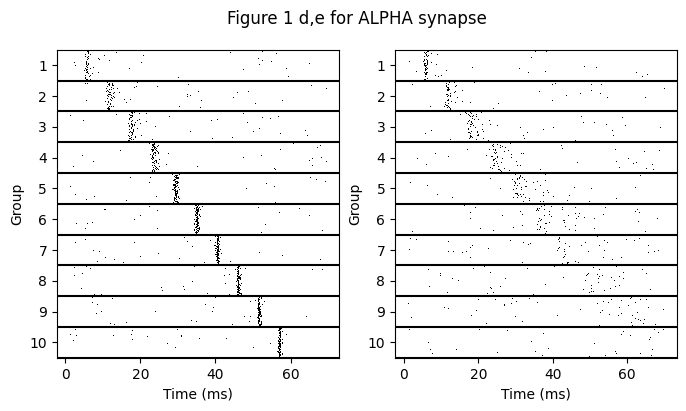

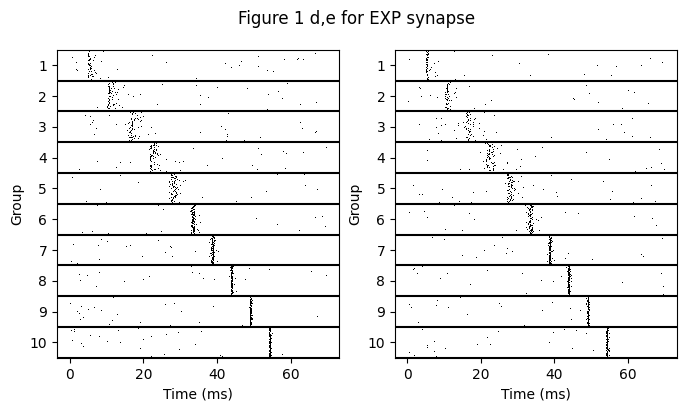

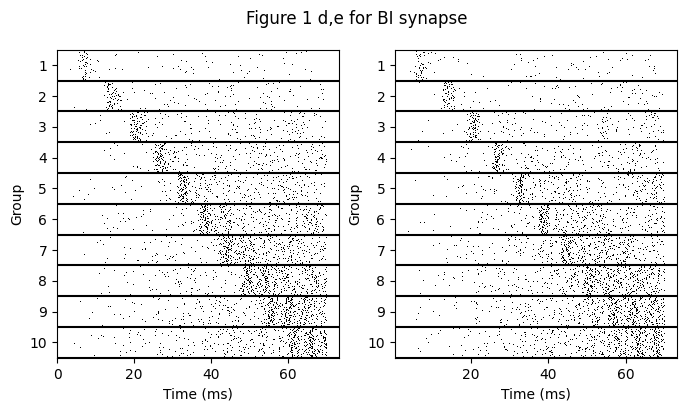

In [46]:
for i, SYNAPSE in enumerate(synapse_types):
    num_neurons = 100
    plt.figure(figsize=(8, 4))
    a_values = [50,48]
    for plotidx, a in enumerate(a_values):
        s = input_burst(num_neurons=num_neurons, num_active=a)
        plt.subplot(1, 2, plotidx+1)
        for layer in range(10):
            s_accumulated = all_to_all(s)
            _, s = simulate_layer_2(spikes_in=s_accumulated)
            i, t = s.nonzero()
            plt.plot(t*0.1, i/100+9-layer, ',k')
            plt.axhline(layer, c='k')
        plt.ylim(0, 10)
        plt.yticks(np.arange(10)+0.5, np.arange(1, 11)[::-1])
        plt.xlabel('Time (ms)')
        plt.ylabel('Group')
    plt.suptitle(f'Figure 1 d,e for {SYNAPSE} synapse')
    plt.plot();
    

## Observations

- The results for the **ALPHA** and **EXP** synapses are favorable, showing consistent and expected patterns of neuronal firing in response to input bursts. This indicates that both models effectively capture the dynamics of neuronal activity in response to stimulation.

- Conversely, the **BI** synapse demonstrates poor performance, with a substantial deviation from expected firing patterns. This discrepancy may be attributed to the complexities of the biexponential model, which might introduce excessive temporal dynamics, leading to overactivity or delayed responses that do not align well with the input burst structure.

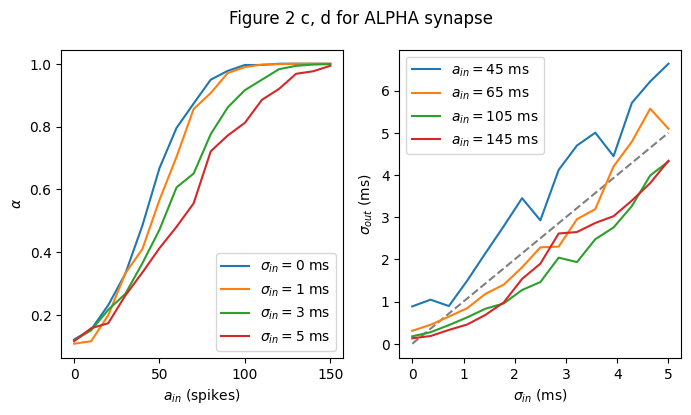

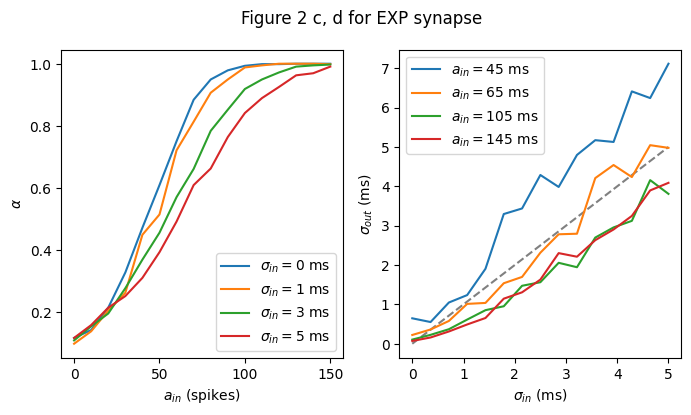

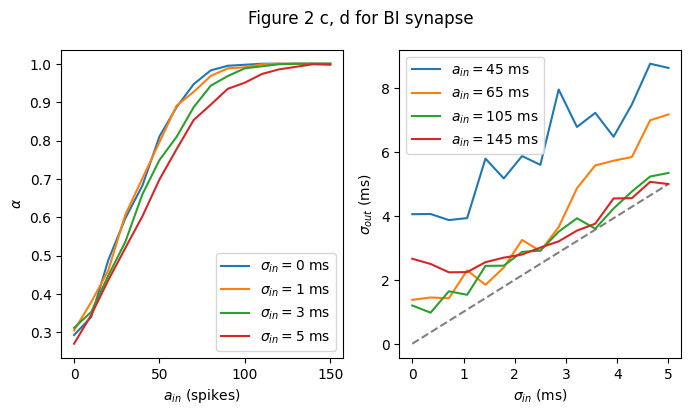

In [47]:
def neural_transmission_2(a_in, sigma_in, repeats=5, dt=0.1):
    cumulative_alpha, cumulative_sigma = 0, 0
    offset = 100
    num_time_steps = 400
    neurons_count = 150
    
    for _ in range(repeats):
        spike_burst = input_burst(num_neurons=neurons_count, num_active=a_in, 
                                  offset=offset, sigma=sigma_in, dt=dt, 
                                  num_time_steps=num_time_steps)
        spike_burst = all_to_all(spike_burst)
        
        _, output_spikes = simulate_layer_2(num_neurons=neurons_count, spikes_in=spike_burst, 
                                          noise=True, num_time_steps=num_time_steps, delay=0)
        
        alpha_iter, sigma_iter = estimate_pulse_parameters(output_spikes, neurons_count)
        cumulative_alpha += alpha_iter
        cumulative_sigma += sigma_iter
    
    avg_alpha = cumulative_alpha / repeats
    avg_sigma = cumulative_sigma / repeats

    return avg_alpha, avg_sigma

for i, SYNAPSE in enumerate(synapse_types):

    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    for sigma in [0, 1, 3, 5]:
        A_IN = np.arange(0, 150+1, 10)
        ALPHA = [neural_transmission_2(a_in, sigma)[0] for a_in in A_IN]
        plt.plot(A_IN, ALPHA, label=f'$\\sigma_{{in}}={sigma}$ ms')
    plt.xlabel(r'$a_{in}$ (spikes)')
    plt.ylabel(r'$\alpha$')
    plt.legend(loc='best')
    plt.subplot(122)
    for a_in in [45, 65, 105, 145]:
        SIGMA_IN = np.linspace(0, 5, 15)
        SIGMA_OUT = [neural_transmission_2(a_in, sigma_in)[1] for sigma_in in SIGMA_IN]
        plt.plot(SIGMA_IN, SIGMA_OUT, label=f'$a_{{in}}={a_in}$ ms')
    plt.plot([0, 5], [0, 5], ls='--', c='grey', zorder=-1)
    plt.xlabel(r'$\sigma_{in}$ (ms)')
    plt.ylabel(r'$\sigma_{out}$ (ms)')
    plt.legend(loc='best')
    plt.suptitle(f'Figure 2 c, d for {SYNAPSE} synapse')

## Observations

All three synapse types—ALPHA, EXP, and BI—exhibited similar results in terms of the output parameters , $\alpha$ and $\sigma$. This convergence in performance can be attributed to several factors:

1. **Robustness of Neural Transmission**: The inherent mechanisms of neural transmission may be robust enough to produce comparable responses across different synapse types when subjected to similar input conditions. Despite the differences in the underlying dynamics, the effective integration of input spikes by the neurons could lead to similar output behaviors.

2. **Input Characteristics and Noise Effects**: The simulations incorporated noise, which might have masked the differences in synaptic responses. If the input characteristics (e.g., spike bursts) are strong enough relative to the noise level, they could dominate the output, leading to consistent results across all synapse models. This suggests that the synaptic dynamics may not have a pronounced effect under certain input conditions, particularly when noise is present.

3. **Simulation Parameters**: The parameters chosen for the simulations, including the number of neurons and the range of input spikes, might not be sufficient to reveal the distinct characteristics of each synapse type. If the operational ranges overlap significantly, the nuances of each model may not become apparent, resulting in similar outputs.

In summary, while the ALPHA, EXP, and BI synapses are based on different theoretical frameworks, their performance can converge under specific conditions, particularly when input dynamics and noise influence the system's behavior similarly across all models.


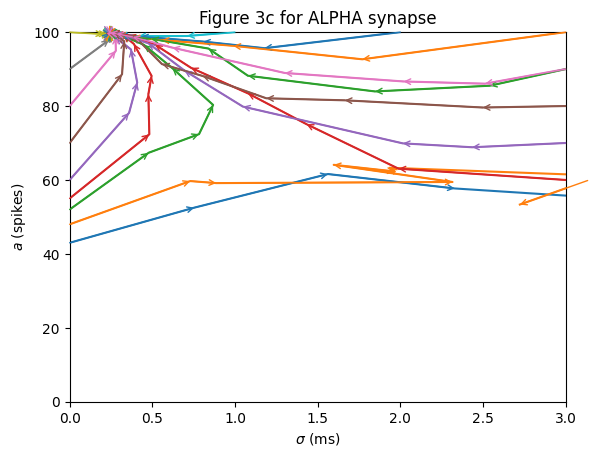

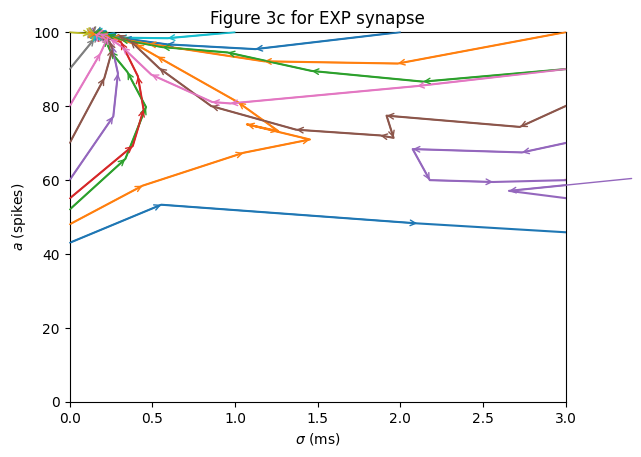

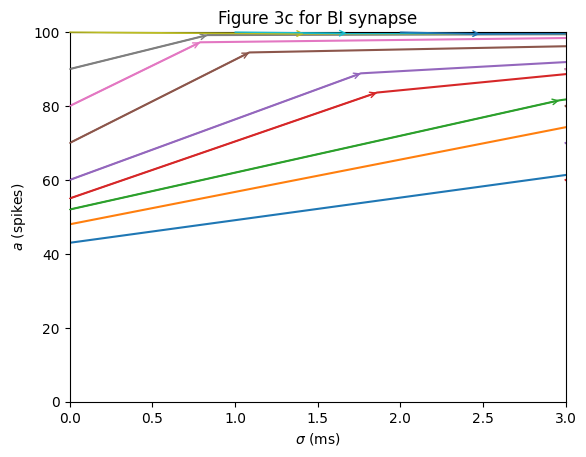

In [48]:

def calculate_mean_values_2(num_neurons, repeats, s):
    """Calculate the mean values of a and sigma over multiple runs."""
    a_sum = 0
    sigma_sum = 0
    
    for _ in range(repeats):
        s_1 = all_to_all(s)
        _, s_1 = simulate_layer_2(num_neurons=num_neurons, spikes_in=s_1, noise=True, num_time_steps=400, delay=0)
        
        alpha_temp, sigma_temp = estimate_pulse_parameters(s_1, num_neurons)
        a_temp = int(alpha_temp * num_neurons)
        
        a_sum += a_temp
        sigma_sum += sigma_temp

    return a_sum/repeats, sigma_sum/repeats, s_1

for i,SYNAPSE in enumerate(synapse_types):
    for idx, (a, sigma) in enumerate(starting_points):
        A, SIGMA = [a], [sigma]
        s = input_burst(num_neurons=num_neurons, num_active=a, offset=offset, sigma=sigma, dt=dt, num_time_steps=400)
    
        for _ in range(10):
            A.append(a)
            SIGMA.append(sigma)
            a, sigma, s = calculate_mean_values_2(num_neurons,repeats,  s)
    
        # Plot results with arrows
        plt.plot(SIGMA, A, c=f'C{idx}')
        for i in range(len(SIGMA) - 1):
            plt.annotate('', (SIGMA[i + 1], A[i + 1]), xytext=(SIGMA[i], A[i]),
                         arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0, color=f'C{idx}'))
    
    plt.xlim(0, 3)
    plt.ylim(0, 100)
    plt.xlabel(r'$\sigma$ (ms)')
    plt.ylabel('$a$ (spikes)')
    plt.title(f'Figure 3c for {SYNAPSE} synapse' )
    plt.show()

## Observations

In comparing the synapse types based on the simulation results, the following conclusions can be drawn:

- **ALPHA Synapse**:
  - The ALPHA synapse demonstrated results that closely aligned with those found in the research paper . This suggests that the dynamics modeled by the ALPHA synapse effectively replicate the underlying mechanisms of synchronous spiking behavior in cortical networks.
  
- **EXP Synapse**:
  - The EXP synapse yielded results that were somewhat similar to those of the ALPHA synapse, but with noticeably worse performance. This indicates that while it retains some benefits of the ALPHA model, it may not fully capture the intricacies of neural dynamics that contribute to stable synchronous spiking.

- **BI Synapse**:
  - The Biexponential (BI) synapse performed poorly in comparison to both the ALPHA and EXP models. Its results indicated significant deviations from expected values, which may reflect its less favorable dynamics for maintaining stable synchronous activity in neural networks.

In summary, the ALPHA synapse stands out for its strong performance consistent with the literature, while the EXP model provides moderate results, and the BI model appears inadequate for the observed phenomena.
